In [155]:
!rm -rf qiskit-optimization/
!git clone https://github.com/morim3/qiskit-optimization

Cloning into 'qiskit-optimization'...
remote: Enumerating objects: 4104, done.
remote: Counting objects: 100% (169/169), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 4104 (delta 95), reused 123 (delta 60), pack-reused 3935
Receiving objects: 100% (4104/4104), 5.16 MiB | 20.33 MiB/s, done.
Resolving deltas: 100% (2708/2708), done.


In [116]:
!nvidia-smi
# !pip install -r qiskit-optimization/requirements-dev.txt
!pip install qiskit-aer-gpu
!pip install docplex
!pip install pylatexenc

import sys
sys.path.append("./qiskit-optimization/")

Thu Dec  1 16:23:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    36W /  70W |    106MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [156]:
%load_ext autoreload
%autoreload

from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit_optimization.algorithms import PQCGroverOptimizer, GroverOptimizer, MinimumEigenOptimizer
from qiskit_optimization.algorithms.pqc_grover_optimizer import ProposeDistribution
from qiskit_optimization.problems import QuadraticProgram
from qiskit_optimization.translators import from_docplex_mp
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.circuit.library import TwoLocal
from docplex.mp.model import Model
import numpy as np
print(Aer.backends())
backend = Aer.get_backend('aer_simulator')
backend.set_options(device='GPU')
backend_statevector = Aer.get_backend('statevector_simulator')
print(backend)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[AerSimulator('aer_simulator'), AerSimulator('aer_simulator_statevector'), AerSimulator('aer_simulator_statevector_gpu'), AerSimulator('aer_simulator_density_matrix'), AerSimulator('aer_simulator_density_matrix_gpu'), AerSimulator('aer_simulator_stabilizer'), AerSimulator('aer_simulator_matrix_product_state'), AerSimulator('aer_simulator_extended_stabilizer'), AerSimulator('aer_simulator_unitary'), AerSimulator('aer_simulator_unitary_gpu'), AerSimulator('aer_simulator_superop'), QasmSimulator('qasm_simulator'), StatevectorSimulator('statevector_simulator'), UnitarySimulator('unitary_simulator'), PulseSimulator('pulse_simulator')]
aer_simulator_gpu


In [157]:
model = Model()
xs = [model.binary_var(name=f"x{i}") for i in range(15)]
objective = sum([np.random.randint(0, 3) * x for x in xs]) + sum([np.random.randint(-2, 3) * x * y for x in xs for y in xs])
# objective = (-xs[0]+2*xs[1]-3*xs[2]-2*xs[0]*xs[2]-1*xs[1]*xs[2])
model.minimize(objective)
qp = from_docplex_mp(model)
print(qp.prettyprint())

Problem name: docplex_model9

Minimize
  x0^2 - 2*x0*x1 - x0*x11 - x0*x12 - 4*x0*x13 + x0*x14 - 2*x0*x2 - 4*x0*x3
  + 2*x0*x4 + x0*x5 - x0*x8 - x1^2 + 2*x1*x10 + 2*x1*x11 + 2*x1*x12 - x1*x13
  + x1*x2 + 2*x1*x3 - x1*x5 - x1*x6 + 2*x1*x7 - 2*x1*x8 - 4*x1*x9 - 2*x10*x11
  - 2*x10*x12 + 2*x10*x13 + x11*x12 - 2*x11*x13 + 4*x11*x14 - 2*x12^2
  + 3*x12*x14 - x13^2 - x13*x14 + x2*x10 + 3*x2*x13 - x2*x14 - x2^2 + 3*x2*x4
  + 2*x2*x6 + 2*x2*x8 + x2*x9 - 4*x3*x10 - x3*x11 + x3*x12 - x3*x14 + 2*x3^2
  + x3*x4 + 2*x3*x5 + x3*x6 + 3*x3*x7 + x3*x8 + x3*x9 + 4*x4*x10 + 2*x4*x11
  - x4*x13 - 4*x4*x14 + x4^2 - x4*x5 + 3*x4*x6 - 3*x5*x10 - x5*x11 - x5*x12
  - 3*x5*x13 - 3*x5*x14 + 2*x5^2 - x5*x6 - x5*x7 - 2*x5*x9 + 2*x6*x10 + 2*x6*x12
  - 3*x6*x13 - 2*x6*x14 + 2*x6^2 + x6*x7 + 4*x6*x8 - x6*x9 + 4*x7*x10 - x7*x11
  - x7*x12 + x7*x13 + 2*x7^2 + x7*x8 - 2*x8*x10 + x8*x11 - x8*x13 + 3*x8*x14
  + 2*x8^2 - 2*x8*x9 + 4*x9*x10 + x9*x12 + 3*x9*x13 + 2*x9*x14 + x9^2 + x1 + x12
  + x13 + 2*x14 + 2*x2 + x4 + 2*x7 +

In [147]:
exact_solver = MinimumEigenOptimizer(NumPyMinimumEigensolver())
exact_result = exact_solver.solve(qp)
print(exact_result.prettyprint())

objective function value: -23.0
variable values: x0=1.0, x1=1.0, x2=0.0, x3=0.0, x4=1.0, x5=0.0, x6=1.0, x7=0.0, x8=0.0, x9=1.0, x10=1.0, x11=0.0, x12=1.0, x13=1.0, x14=0.0
status: SUCCESS


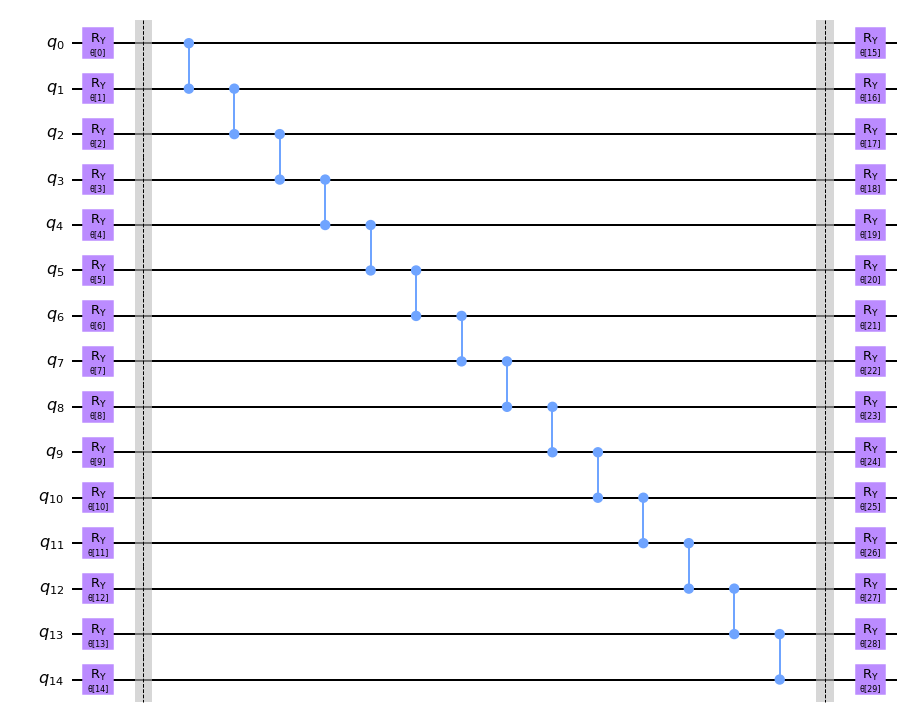

In [148]:
num_key_qbits = len(qp.objective.linear.to_array())
ansatz = TwoLocal(num_key_qbits, 'ry', 'cz', 'linear', reps=1, insert_barriers=True)
ansatz.decompose().draw("mpl")


In [149]:
# from qiskit import execute, QuantumCircuit, transpile

# ansatz_bound = ansatz.assign_parameters(np.array([0.] * num_key_qbits+[np.arcsin(np.sqrt(0.5))*2]*num_key_qbits))

# qc = QuantumCircuit(num_key_qbits)
# # qc.h(range(num_key_qbits))
# qc.compose(ansatz_bound, inplace=True)

# qc = transpile(qc, backend=backend_statevector)
# result = backend_statevector.run(qc).result()
# result.get_statevector(qc)

In [159]:
print(ansatz.num_parameters)
propose_distribution = ProposeDistribution(
    ansatz,                 
    num_key_qbits, 
    QuantumInstance(backend=backend, shots=100, seed_simulator=99),
    init_param=np.array([0.] * num_key_qbits+[np.arcsin(np.sqrt(0.5))*2]*num_key_qbits)
    )
grover_optimizer = PQCGroverOptimizer(
    num_value_qubits=8, 
    propose_dist=propose_distribution,
    num_iterations=15, 
    quantum_instance=backend,      
    sample_num=1, quantile=0., )
results = grover_optimizer.solve(qp)
print(results.prettyprint())
print(results.operation_counts)

30
sampled [0 1 0 0 1 1 1 1 0 0 0 1 1 0 0]
value 15
real_val 15.0
sampled [0 0 0 0 0 0 0 0 0 1 0 1 0 1 0]
value 2
real_val 2.0
sampled [0 0 1 1 1 1 1 0 1 0 1 1 1 1 0]
value 22
real_val 22.0
sampled [1 1 0 1 0 0 1 0 0 1 0 1 0 1 1]
value -4
real_val -4.0


ValueError: ignored

In [ ]:
def eval_num(operation_dict):
    eval_num = 0
    for x in operation_dict.values():
        eval_num += x['Q(x)']
        if 'Q' in x:
            eval_num += x['Q']
    return eval_num

In [ ]:
eval_num(results.operation_counts)

91

In [ ]:
grover_optimizer = GroverOptimizer(8, num_iterations=15, quantum_instance=backend,)
results = grover_optimizer.solve(qp)
print(results.prettyprint())
print(results.operation_counts)

objective function value: -26.0
variable values: x0=1.0, x1=1.0, x2=1.0, x3=1.0, x4=1.0, x5=0.0, x6=1.0, x7=0.0, x8=1.0, x9=0.0, x10=0.0, x11=1.0, x12=0.0, x13=0.0, x14=1.0
status: SUCCESS
{0: OrderedDict([('measure', 24), ('h', 15), ('Q(x)', 1)]), 1: OrderedDict([('measure', 24), ('h', 15), ('Q(x)', 1)]), 2: OrderedDict([('measure', 24), ('h', 15), ('Q(x)', 1)]), 3: OrderedDict([('measure', 24), ('h', 15), ('Q', 2), ('Q(x)', 1)]), 4: OrderedDict([('measure', 24), ('h', 15), ('Q', 3), ('Q(x)', 1)]), 5: OrderedDict([('measure', 24), ('h', 15), ('Q(x)', 1)]), 6: OrderedDict([('measure', 24), ('h', 15), ('Q(x)', 1), ('Q', 1)]), 7: OrderedDict([('measure', 24), ('h', 15), ('Q(x)', 1)]), 8: OrderedDict([('measure', 24), ('h', 15), ('Q(x)', 1), ('Q', 1)]), 9: OrderedDict([('measure', 24), ('h', 15), ('Q(x)', 1)]), 10: OrderedDict([('measure', 24), ('h', 15), ('Q', 3), ('Q(x)', 1)]), 11: OrderedDict([('measure', 24), ('h', 15), ('Q(x)', 1), ('Q', 1)]), 12: OrderedDict([('measure', 24), ('h', 

In [ ]:
eval_num(results.operation_counts)

119